In [ ]:
"""
import packages
"""
import os, glob
import json
import pandas as pd
import numpy as np
import math, random
from datetime import datetime
import pickle
from matplotlib import pyplot as plt
import argparse
import path, sys, re, time
from collections import Counter
from scipy.spatial import distance_matrix
from scipy.signal import find_peaks

In [ ]:
"""
import custom packages
"""
from module_.info.testbed_info import d_files, g_files, c_files, p_files
from module_.info.config import config, feature_name
from module_.readText import create_episodes, time_correction, create_episodes_intra
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection
from module_.evaluation import episode_evaluation

In [ ]:
"""
load raw files
"""
dir_="dataset/testbed/discrete/"
task_dict={
    0:  [np.load(dir_+file_name) for file_name in g_files.keys()],
    1:  [np.load(dir_+file_name) for file_name in d_files.keys()],
    2:  [np.load(dir_+file_name) for file_name in c_files.keys()],
    3:  [np.load(dir_+file_name) for file_name in p_files.keys()]
}
name_dict={
    0: 'G', 1: 'D', 2: 'C', 3: 'P'
}

sensor_set=set()
for k, v in task_dict.items():
    for array in v:
        sensor_set=sensor_set|set(array[:,0])
sensor_list=list(sorted(sensor_set))

episodes, trs, tags = create_episodes(task_dict, name_dict)

In [126]:
# tp_ = fp_ = tn_ = fn_ = 0
thetas_p, sigmas_p, lambdas_p, features_p, events_p = [], [], [], [], []
for e_num in range(len(episodes)):
    print("{}/{}".format(e_num, len(episodes)))
    tag, gt, eps=tags[e_num], trs[e_num], time_correction(np.array(episodes[e_num]), trs[e_num])
    features=np.array(feature_extraction(eps, "testbed", sensor_list))
    scores, thetas, sigmas, lambdas=change_point_detection(features, 'sep', analyze=True)
    scores=np.array(scores)
    # peak, _=find_peaks(np.array(scores))
    peak=np.array([p for p in range(len(scores)) if scores[p]>0.3])

    for p in peak:
        left=max(0, p-31); right=min(len(eps)-1, p+2)
        events_p.append(eps[left:right])
    thetas_p+=[thetas[p] for p in peak]
    sigmas_p+=[sigmas[p] for p in peak]
    lambdas_p+=[lambdas[p] for p in peak]
    temp=[]
    for p in peak:
        prev1=max(0, p-1)
        post1=min(len(features)-1, p+1)
        post2=min(len(features)-1, p+2)
        l=[features[prev1], features[p], features[post1], features[post2]]
        temp.append(np.concatenate(l).reshape((4,-1)))
    features_p+=temp

    # print(peak)
    # plt.title('GroupStudy-Discussion')
    # plt.xlabel('events'); plt.ylabel('score')
    # plt.plot(range(len(scores)), scores, 'ro-')
    # plt.plot(peak, scores[peak], '*', label="candidates")
    # plt.axvline(x=gt, linestyle=':', label="transition")
    # plt.legend()
keyword='false'
with open("./statistics/events_p_false", 'wb') as f:
    pickle.dump(events_p, f)
# np.save("./statistics/thetas_p_true.npy", thetas_p)
# np.save("./statistics/sigmas_p_true.npy", sigmas_p)
# np.save("./statistics/lambdas_p_true.npy", lambdas_p)
# np.save("./statistics/features_p_true.npy", features_p)

0/300
1/300
2/300
3/300
4/300
5/300
6/300
7/300
8/300
9/300
10/300
11/300
12/300
13/300
14/300
15/300
16/300
17/300
18/300
19/300
20/300
21/300
22/300
23/300
24/300
25/300
26/300
27/300
28/300
29/300


KeyboardInterrupt: 

In [129]:
events_p_=[l for l in events_p if len(l)==33]

In [132]:
events_p_[:5]

[array([['MT1', 'false', '1529058455.147'],
        ['MT1', 'true', '1529058655.148'],
        ['SE2A', 'false', '1529058655.148'],
        ['MT9', 'true', '1529058658.241'],
        ['MT3', 'true', '1529058659.241'],
        ['SE5B', 'true', '1529058666.953'],
        ['SE2B', 'false', '1529058669.364'],
        ['MT1', 'true', '1529058685.364'],
        ['MT9', 'true', '1529058688.642'],
        ['MT3', 'true', '1529058689.642'],
        ['MT1', 'false', '1529058721.685'],
        ['MT9', 'false', '1529058725.686'],
        ['MT3', 'false', '1529058726.686'],
        ['SE3B', 'false', '1529059075.945'],
        ['SE5B', 'true', '1529059260.415'],
        ['MT3', 'true', '1529059374.283'],
        ['SE5B', 'false', '1529059377.725'],
        ['MT9', 'true', '1529059378.725'],
        ['SE6B', 'true', '1529059393.213'],
        ['MT3', 'true', '1529059404.555'],
        ['MT9', 'true', '1529059408.964'],
        ['MT3', 'false', '1529059441.959'],
        ['MT9', 'false', '1529059445.9

In [118]:
keyword='false'
features_p=np.load("./statistics/features_p_{}.npy".format(keyword))
sigmas_p=np.load("./statistics/sigmas_p_{}.npy".format(keyword))
lambdas_p=np.load("./statistics/lambdas_p_{}.npy".format(keyword))
thetas_p=np.load("./statistics/thetas_p_{}.npy".format(keyword))

In [119]:
# A__=[]; B__=[]
ll=[]
for feature_ in features_p:
    l=[]
    for col in range(feature_.shape[1]):
        column=feature_[:,col]
        if max(column)!=min(column):
            test_=np.matrix([[np.linalg.norm(a-b)**2 for b in column[:2]] for a in column[:2]])
            train_=np.matrix([[np.linalg.norm(a-b)**2 for b in column[2:]] for a in column[:2]])
            # l.append((col, train_.mean()))
            l.append((col, test_.mean()/train_.mean()))
    ll+=l
    # beforev, afterv=feature_[:2], feature_[2:]
    # test_=[[np.linalg.norm(b-b_)**2 for b_ in beforev] for b in beforev]
    # train_=[[np.linalg.norm(b-a)**2 for a in afterv] for b in beforev]
    # A__.append(np.matrix(test_))
    # B__.append(np.matrix(train_))

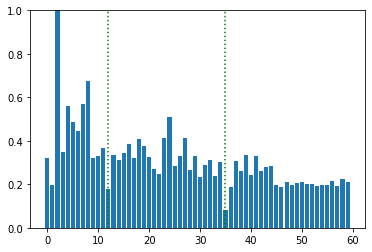

In [122]:
A=Counter(ll)
dict_={item:[] for item in range(60)}
for k, v in ll:
    dict_[k].append(v)
x, y = [], []
for k, v in dict_.items():
    x.append(k)
    y.append(sum(v)/len(v))
plt.ylim(0, 1)
plt.bar(x, y)
plt.axvline(x=12, linestyle=':', color='g')
plt.axvline(x=35, linestyle=':', color='g')

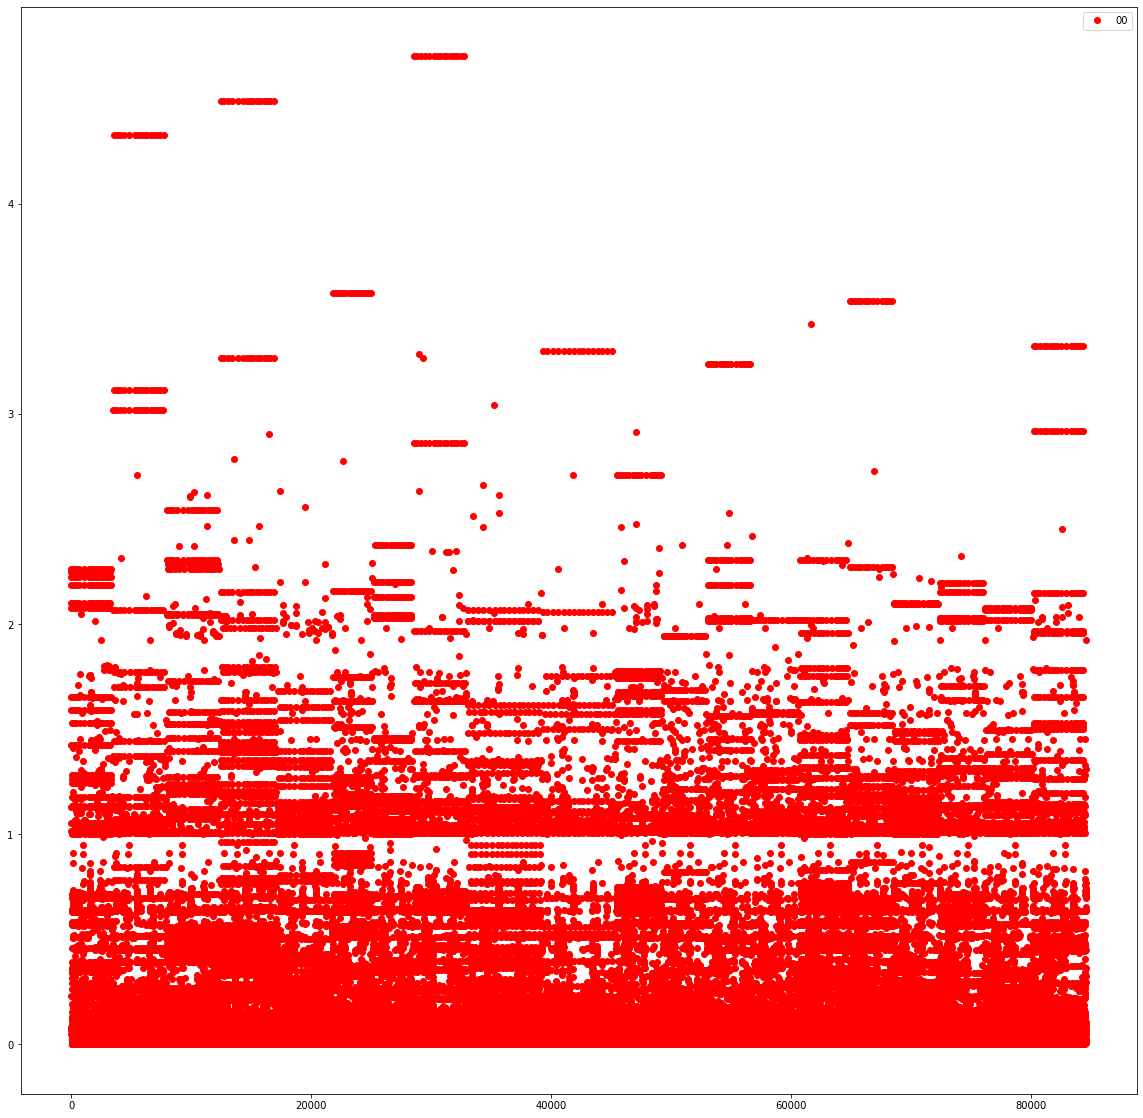

In [81]:
fig, ax = plt.subplots(figsize=(20,20))
x_=range(len(A__))
train_00=[train[0,0] for train in B__]
train_01=[train[0,1] for train in B__]
train_10=[train[1,0] for train in B__]
train_11=[train[1,1] for train in B__]
# ax.plot(x_, train_00, 'ro', label="00")
# ax.plot(x_, train_01, 'go-', label="01")
# ax.plot(x_, train_10, 'bo-', label="10")
# ax.plot(x_, train_11, 'co-', label="11")
ax.legend()
# plt.savefig("./statistics/graph/{}_alarm.png".format(keyword))

In [ ]:
# plt.ylim(0, 3)
plt.plot(range(len(B__)), B__)

In [ ]:
theta_means=[theta_.mean() for theta_ in thetas_p]
plt.ylim(0, 0.2)
plt.plot(range(len(theta_means)), theta_means, 'ro-')
plt.yticks([min(theta_means), max(theta_means)])
plt.axhline(min(theta_means),linestyle=':')
plt.axhline(max(theta_means),linestyle=':')

In [ ]:
max_len=max([len(eps) for eps in episodes])
transition_occurrences={}
transition_occurrences={}
for k in task_dict.keys():
    print(name_dict[k])
    same_activities={i:task for i, task in enumerate(task_dict[k])}
    same_episodes, same_trs = create_episodes_intra(same_activities)

    # max_len=max([len(eps) for eps in same_episodes])

    for e_num in range(len(same_episodes)):
        test_gt, test=same_trs[e_num], same_episodes[e_num]
        sensor_list=list(sorted(set(test[:,0])))
        features=feature_extraction(test, "testbed"); features=np.array(features)
        scores=change_point_detection(features, 'sep')

        part_scores=np.array(scores)
        part_scores[part_scores<0.3]=0
        part_events=test

        if test_gt-30<0 or test_gt+30>=len(test):
            continue
        range_transition_nearby=range(test_gt-30, test_gt+30)

        alarms=0
        for i in range_transition_nearby:
            if part_scores[i]>0.3:
                alarms+=1

        label=name_dict[k]

        if label not in transition_occurrences.keys():
            transition_occurrences[label]={"alarms":0, "combinations":0}
            transition_occurrences[label]['alarms']+=alarms
            transition_occurrences[label]['combinations']+=1
        else:
            transition_occurrences[label]['alarms']+=alarms
            transition_occurrences[label]['combinations']+=1

print(transition_occurrences)

In [ ]:
for k in transition_occurrences.keys():
    print(k, transition_occurrences[k]['alarms']/transition_occurrences[k]['combinations'])

In [ ]:
part_scores=np.array(scores)
part_events=test

part_scores_sum=[]
for i in range(len(part_scores)):
    prev1, prev2 = max(0, i-1), max(0, i-2)
    part_scores_sum.append(part_scores[prev1]+part_scores[prev2])

scores=np.array(part_scores_sum)
scores[scores<0.9]=0
plt.plot(range(len(scores)), scores)
plt.title(tag)

plt.axvline(x=test_gt, linestyle=":", color='g')
plt.axvspan(xmin=0, xmax=30, alpha=0.2)

In [ ]:
positives_=np.array([i for i in range(len(part_scores)) if part_scores_sum[i]>0.9])
print(positives_)
timestamp_=float(test[test_gt][2])

true_positive = false_positive = true_negative = false_negative = 0
target_positive, target_time=positives_, timestamp_
flag=True
for i, event in enumerate(part_events):
    if i in target_positive: # POSITIVE
        if i==test_gt:
            true_positive+=1
        else:
            event_time=float(event[2])
            if abs(event_time-timestamp_)<60:
                true_positive+=1
            else:
                false_positive+=1
    else:   # NEGATIVE
        if i==test_gt:
            false_negative+=1
        else:
            true_negative+=1
print(test_gt)
print(true_positive, false_positive, true_negative, false_negative)
true_positive/(true_positive+false_negative), false_positive/(false_positive+true_negative)